# Create dataset from yolo's dataset

In [ ]:
!unzip "/content/egg detection label.v1i.yolov8.zip" -d "/content/egg-detection-label-yolov8"

In [1]:
import os
import cv2

dataset_path = "/content/egg-detection-label-yolov8"
image_dir = "/content/egg-detection-label-yolov8/train/images"
labels_dir = "/content/egg-detection-label-yolov8/train/labels"
output_dir = "/content/egg-cropped"

os.makedirs(output_dir, exist_ok=True)

for label_file in os.listdir(labels_dir):
  if not label_file.endswith(".txt"):
    continue

  image_name = label_file.replace(".txt", ".jpg")
  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
    continue

  img = cv2.imread(image_path)
  h, w, _ = img.shape

  with open(os.path.join(labels_dir, label_file), "r") as f:
    for i, line in enumerate(f):
      class_id, x_center, y_center, width, height = map(float, line.strip().split())

      x_center *= w
      y_center *= h
      width *= w
      height *= h

      x1 = int(x_center - width / 2)
      y1 = int(y_center - height / 2)
      x2 = int(x_center + width / 2)
      y2 = int(y_center + height / 2)

      crop = img[y1:y2, x1:x2]

      if crop.size == 0:
        continue

      # create folder
      class_folder = os.path.join(output_dir, f"class{int(class_id)}")
      os.makedirs(class_folder, exist_ok=True)

      # save img
      output_path = os.path.join(class_folder, f"{image_name[:-4]}_{i}.jpg")
      cv2.imwrite(output_path, crop)

In [2]:
!mv "/content/egg-cropped/class0" "/content/egg-cropped/Damaged"
!mv "/content/egg-cropped/class1" "/content/egg-cropped/Not Damaged"

In [ ]:
dataset_dir = '/content/egg-cropped'

classes = os.listdir(dataset_dir)
print(f"classes: {classes}")

for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    print(f"{cls}: {len(os.listdir(cls_path))} images")

classes: ['Damaged', 'Not Damaged']
Damaged: 728 images
Not Damaged: 177 images


# 2 Stages model

## classification model

In [3]:
import shutil
from sklearn.model_selection import train_test_split

dataset_dir = "/content/egg-cropped"
output_dir = "/content/egg-split-cropped"

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")
test_dir = os.path.join(output_dir, "test")

for d in [train_dir, val_dir, test_dir]:
  os.makedirs(d, exist_ok=True)

val_size = 0.15
test_size = 0.15

for class_name in os.listdir(dataset_dir):
  class_path = os.path.join(dataset_dir, class_name)
  if not os.path.isdir(class_path):
    continue

  images = os.listdir(class_path)
  images = [img for img in images if img.endswith(('.jpg'))]

  train_imgs, temp_imgs = train_test_split(images, test_size=(val_size + test_size), random_state=42)
  val_imgs, test_imgs = train_test_split(temp_imgs,test_size=test_size / (val_size + test_size), random_state=42)

  # copy files
  for split, split_imgs in zip(
      [train_dir, val_dir, test_dir],
      [train_imgs, val_imgs, test_imgs]
  ):
    split_class_dir = os.path.join(split, class_name)
    os.makedirs(split_class_dir, exist_ok=True)
    for img_name in split_imgs:
      shutil.copy(os.path.join(class_path, img_name), os.path.join(split_class_dir, img_name))



In [ ]:
!unzip '/content/egg-split-cropped-new.zip' -d '/content/egg-split-cropped-new'

In [4]:
import tensorflow as tf

data_dir = '/content/egg-split-cropped'
IMAGE_SIZE = 224
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "train"),
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "val"),
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, "test"),
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# normalizing and caching
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(ds, training=False):
    if training:
        ds = ds.shuffle(1000)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = preprocess(train_ds)
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)



Found 632 files belonging to 2 classes.
Found 136 files belonging to 2 classes.
Found 137 files belonging to 2 classes.


In [5]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # freeze base

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
for c in os.listdir('/content/egg-split-cropped-new/egg-split-cropped/train'):
    print(c, len(os.listdir(os.path.join('/content/egg-split-cropped-new/egg-split-cropped/train', c))))


Damaged 491
Not Damaged 110


In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
  )

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 961ms/step - accuracy: 0.7900 - loss: 0.5090 - val_accuracy: 0.8015 - val_loss: 0.4468
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.8126 - loss: 0.4559 - val_accuracy: 0.8235 - val_loss: 0.4181
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.8127 - loss: 0.4212 - val_accuracy: 0.8382 - val_loss: 0.3916
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.8421 - loss: 0.3804 - val_accuracy: 0.8309 - val_loss: 0.3769
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.8417 - loss: 0.3719 - val_accuracy: 0.8382 - val_loss: 0.3615
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.8441 - loss: 0.3401 - val_accuracy: 0.8529 - val_loss: 0.3482
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.8348 - loss: 0.3527 - val_accuracy: 0.8750 - val_loss: 0.3393
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.8427 - loss: 0.3324 - val_accuracy: 0

In [ ]:
!zip -r "/content/egg-split-cropped.zip" "/content/egg-split-cropped"

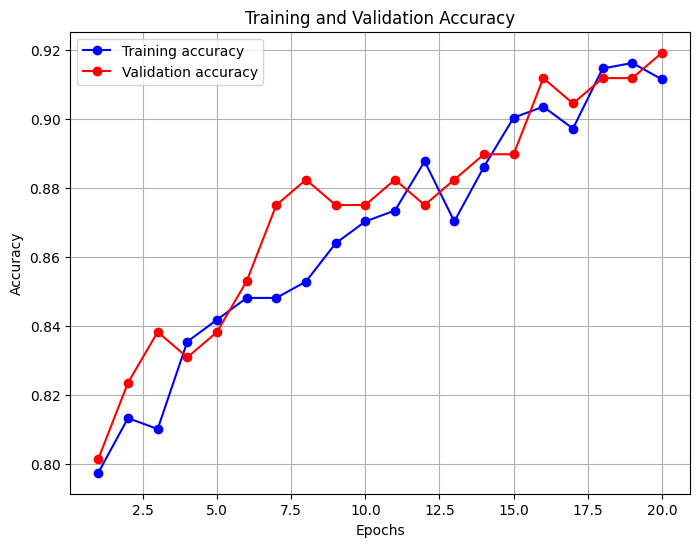

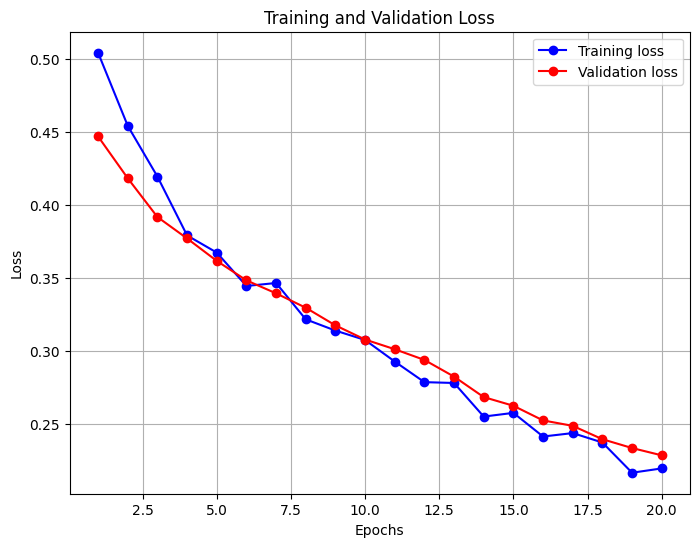

In [7]:
import matplotlib.pyplot as plt

# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8534 - loss: 0.2618


[0.2735450863838196, 0.8467153310775757]

## Train object detection model

In [ ]:
!unzip "/content/egg-no-label.zip" -d "/content/egg-no-label"

In [ ]:
!pip install ultralytics

In [9]:
from ultralytics import YOLO

In [10]:
model = YOLO('yolov8s.pt')

In [11]:
model.train(
    data='/content/egg-no-label/data.yaml',
    epochs=30,
    imgsz=512,
    batch=32,
    name='egg_detection'
)


Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/egg-no-label/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=egg_detection6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79c533237f20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
metrics = model.val()
results = model.predict(source='/content/egg-no-label/test/images/damaged_188_jpg.rf.46d06ab475646a46d8a904aef6f5a292.jpg', show=True)

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1325.6±601.6 MB/s, size: 140.7 KB)
val: Scanning /content/egg-no-label/valid/labels.cache... 126 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 126/126 272.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.2it/s 3.7s
                   all        126        150      0.849      0.778       0.82       0.49
                Damage         94        112        0.9       0.83      0.878      0.511
             NotDamage         32         38      0.797      0.725      0.763      0.469
Speed: 4.0ms preprocess, 5.6ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to /content/runs/detect/val2

